# Data Preprocessing

In [1]:
import pandas as pd
import shap
import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def data_preprocessing(file_path:str,location:list[int])->pd.DataFrame:
    """preprocessing the data

    Args:
        file_path (str): the csv path
        location (list[int]): the location you want to extract

    Returns:
        pd.DataFrame: the processed dataframe
    """
    # 1. read data, select data in the certain locations
    weather_data = pd.read_csv(file_path)
    local_data = weather_data[weather_data['Location'].isin(location)]
    local_data.drop(columns=['Location'],inplace=True)
    # 2. handle the data with date type
    local_data['Date'] = pd.to_datetime(local_data['Date'])
    local_data['Month'] = local_data['Date'].dt.month
    
    def categorize_day(day:int)->str:
        if day <= 10:
            return '1'
        elif day <= 20:
            return '2'
        else:
            return '3'
        
    local_data['DayGroup'] = local_data['Date'].dt.day.apply(categorize_day)
    local_data.drop(columns=['Date','WindGustDir', 'WindGustSpeed','Cloud9am', 'Cloud3pm','RainToday','RainTomorrow'],inplace=True)
    
    
    # 3. Fill Nans
    columns_to_fill = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
    'Pressure9am', 'Pressure3pm',
    'Temp9am', 'Temp3pm'
    ]
    for col in columns_to_fill:
        local_data[col] = local_data[col].fillna(local_data[col].rolling(window=10, min_periods=1, center=True).mean())

    columns_to_fill_with_prev_day = ['WindDir9am', 'WindDir3pm']
    for col in columns_to_fill_with_prev_day:
        local_data[col] = local_data[col].fillna(method='ffill')
        
    # 4. Encode the categorical data
    one_hot_encoded_data = pd.get_dummies(local_data, columns=['WindDir9am', 'WindDir3pm','Month', 'DayGroup'])
    
    # 5. Normalize the columns
    columns_to_normalize = [
    'MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine',
    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
    'Humidity3pm', 'Pressure9am', 'Pressure3pm',
    'Temp9am', 'Temp3pm'
    ]   
    
    scaler = MinMaxScaler()
    one_hot_encoded_data[columns_to_normalize] = scaler.fit_transform(one_hot_encoded_data[columns_to_normalize])
    
    return one_hot_encoded_data.dropna()


In [3]:
# test  Brisbane,Townsville,Melbourne
data_preprocessing("weatherAUS.csv",["Melbourne"])

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayGroup_1,DayGroup_2,DayGroup_3
67200,0.297794,0.155313,2.0,0.117647,0.503597,0.552239,0.460526,0.534884,0.340426,0.357285,...,False,True,False,False,False,False,False,True,False,False
67201,0.352941,0.130790,0.6,0.218487,0.287770,0.447761,0.460526,0.604651,0.489362,0.489022,...,False,True,False,False,False,False,False,True,False,False
67202,0.257353,0.119891,1.4,0.084034,0.057554,0.253731,0.315789,0.674419,0.553191,0.716567,...,False,True,False,False,False,False,False,True,False,False
67203,0.283088,0.130790,0.6,0.075630,0.302158,0.134328,0.092105,0.848837,0.457447,0.824351,...,False,True,False,False,False,False,False,True,False,False
67204,0.106618,0.158038,0.0,0.033613,0.604317,0.358209,0.394737,0.779070,0.489362,0.798403,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70388,0.235294,0.103542,0.6,0.025210,0.000000,0.029851,0.118421,1.000000,0.787234,0.796407,...,True,False,False,False,False,False,False,False,False,True
70389,0.194853,0.119891,0.2,0.025210,0.000000,0.134328,0.144737,0.918605,0.531915,0.784431,...,True,False,False,False,False,False,False,False,False,True
70390,0.220588,0.141689,0.0,0.067227,0.431655,0.253731,0.250000,0.732558,0.606383,0.596806,...,True,False,False,False,False,False,False,False,False,True
70391,0.253676,0.070845,1.4,0.075630,0.402878,0.164179,0.026316,0.709302,0.606383,0.594810,...,True,False,False,False,False,False,False,False,False,True


In [4]:
def shap_analysis(regressor,X_test:np.ndarray,Y_pred:np.ndarray,Y_test:np.ndarray):
    # 1. change data type
    X_test = X_test.copy(True)
    bool_colmns = X_test.select_dtypes(include=['bool']).columns
    X_test[bool_colmns] = X_test[bool_colmns].astype('float64')
    
    # 2. explain the model with SHAP
    explainer_xgb = shap.Explainer(regressor, X_test)
    shap_values_xgb = explainer_xgb(X_test)
    
    # 3. plot the sample with the maximum residual
    if not isinstance(Y_test,np.ndarray):
        Y_test = Y_test.values
    y_residual = np.abs(Y_pred - Y_test)
    max_residual_indexes = np.argsort(y_residual)
    print("This is the waterfall plot of the sample with the maximum residual {}".format(y_residual[max_residual_indexes[-1]]))
    shap.plots.waterfall(shap_values_xgb[max_residual_indexes[-1]])
    # 4. plot the sample with the minimum residual
    print("This is the waterfall plot of the sample with the minimum residual {}".format(y_residual[max_residual_indexes[0]]))
    shap.plots.waterfall(shap_values_xgb[max_residual_indexes[0]])
    # 5. sum contribution
    shap.plots.bar(shap_values_xgb.abs.mean(0))

# Xgboost Regression

In [5]:
def xgboost_regression(input_data:pd.DataFrame):
    # 1. define the features and the labels
    X = input_data.drop('Rainfall', axis=1)
    Y = input_data['Rainfall']
    # 2. split the data into training and validation sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    # 3. init the model
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,
                          max_depth = 100, alpha = 10, n_estimators = 200)
    xg_reg.fit(X_train, Y_train)
    Y_pred = xg_reg.predict(X_test)
    mse_test = mean_squared_error(Y_test, Y_pred)
    # 4. plot
    plt.figure(figsize=(15, 6))
    plt.plot(Y_pred[:100], 'r-', label='Predicted Rainfall')
    plt.plot(Y_test.values[:100], 'b-', label='Actual Rainfall')
    plt.title(f'Comparison of Predicted and Actual Rainfall - Test MSE: {mse_test:.2f}')
    plt.xlabel('Sample Index')
    plt.ylabel('Rainfall')
    plt.legend()
    plt.show()
    
    # 5. Extracting feature importance and selecting the top 10 features
    feature_importance = xg_reg.get_booster().get_score(importance_type="weight")
    sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:20]
    top_features_df = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'])
    plt.figure(figsize=(10, 6))
    plt.barh(top_features_df['Feature'], top_features_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances in XGBoost Model')
    plt.gca().invert_yaxis()  # To display the highest importance at the top
    plt.show()
    
    print("MSE of {} is :{}".format(xg_reg,mse_test))
    
    # 6. shap anlaysis
    shap_analysis(xg_reg,X_test,Y_pred,Y_test)
    return xg_reg

# Ridge

In [6]:
def ridge_regression(input_data:pd.DataFrame):
    SELECTED_FEATURES =[
                        'Humidity9am',
                        'WindSpeed9am',
                        'Pressure3pm',
                        'WindDir9am_SE',
                        'WindDir9am_S',
                        'WindSpeed3pm',
                        'MinTemp',
                        'Evaporation',
                        'Temp9am',
                        'Sunshine',
                        'Month_4',
                        'Month_3',
                        'Month_6',
                        'WindDir3pm_NNE',
                        'WindDir9am_ESE']
    # 1. define the features and the labels
    X = input_data.drop('Rainfall', axis=1)
    Y = input_data['Rainfall']
    # 2. split the data into training and validation sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    # 3. select the features
    X_train_selected = X_train[SELECTED_FEATURES]
    X_test_selected = X_test[SELECTED_FEATURES]
    # 4. construct the regressor and fit it
    ridge_reg = Ridge(alpha=0.4)
    ridge_reg.fit(X_train_selected, Y_train)
    Y_pred_ridge = ridge_reg.predict(X_test_selected)
    mse_test_ridge = mean_squared_error(Y_test, Y_pred_ridge)
    # 5. plot feature importance
    ridge_coefficients = ridge_reg.coef_
    ridge_feature_importance = pd.DataFrame({
        'Feature': X_train_selected.columns,
        'Coefficient': ridge_coefficients
    })

    ridge_feature_importance = ridge_feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(ridge_feature_importance['Feature'], ridge_feature_importance['Coefficient'])
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.title('Feature Importance in Ridge Regression Model')
    plt.gca().invert_yaxis()
    plt.show()
    # 6. plot the regression results
    plt.figure(figsize=(15, 6))
    plt.plot(range(100),Y_pred_ridge[:100], 'r-', label='Predicted Rainfall (Ridge Regression)')
    plt.plot(range(100),Y_test[:100], 'b-', label='Actual Rainfall')
    plt.title(f'Comparison of Predicted and Actual Rainfall (Ridge Regression) - Test MSE: {mse_test_ridge:.2f}')
    plt.xlabel('Sample Index')
    plt.ylabel('Rainfall')
    plt.legend()
    plt.show()
    
    print("MSE of {} is :{}".format(ridge_reg,mse_test_ridge))
    
    # 6. shap anlaysis
    shap_analysis(ridge_reg,X_test_selected,Y_pred_ridge,Y_test)
    return ridge_reg

# Gaussian process

In [7]:
def gaussian_process(input_data:pd.DataFrame):
    SELECTED_FEATURES =[
                        'Humidity9am',
                        'WindSpeed9am',
                        'Pressure3pm',
                        'WindDir9am_SE',
                        'WindDir9am_S',
                        'WindSpeed3pm',
                        'MinTemp',
                        'Evaporation',
                        'Temp9am',
                        'Sunshine',
                        'Month_4',
                        'Month_3',
                        'Month_6',
                        'WindDir3pm_NNE',
                        'WindDir9am_ESE']
    # 1. define the features and the labels
    X = input_data.drop('Rainfall', axis=1)
    Y = input_data['Rainfall']
    # 2. split the data into training and validation sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    # 3. select the features
    X_train_selected = X_train[SELECTED_FEATURES]
    X_test_selected = X_test[SELECTED_FEATURES]
    # 4. construct the model and fit it
    kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=4,random_state=1)
    gp.fit(X_train_selected, Y_train)
    Y_pred_gp, Y_std_gp = gp.predict(X_test_selected, return_std=True)
    mse_test_gp = mean_squared_error(Y_test, Y_pred_gp)
    # 5. plot the results
    plt.figure(figsize=(15, 6))
    plt.plot(range(100),Y_pred_gp[:100], 'r-', label='Predicted Rainfall (Gaussian Process)')
    plt.fill_between(range(100), Y_pred_gp[:100] - Y_std_gp[:100], Y_pred_gp[:100] + Y_std_gp[:100], color='gray', alpha=0.2)
    plt.plot(range(100),Y_test[:100], 'b-', label='Actual Rainfall')
    plt.title(f'Comparison of Predicted and Actual Rainfall (Gaussian Process) - Test MSE: {mse_test_gp:.2f}')
    plt.xlabel('Sample Index')
    plt.ylabel('Rainfall')
    plt.legend()
    plt.show()
    
    
    print("MSE of {} is :{}".format(gp,mse_test_gp))
    
    # 6. shap anlaysis
    # shap_analysis(gp,X_test_selected,Y_pred_gp,Y_test)
    return gp

# Long-Short Term Memory

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

DEVICE ="cuda" if torch.cuda.is_available() else "cpu"

class LSTM(nn.Module):
    """Definition of LSTM module
    """
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions[:,-1,:]

def lstm(input_data:pd.DataFrame,hidden_size =100):
    # 1. Define the features and the labels
    def create_sequences(data:pd.DataFrame, seq_length:int):
        xs, ys = [], []
        for i in range(len(data)-seq_length):
            x = data.drop('Rainfall', axis=1).values[i:(i+seq_length)]
            y = data['Rainfall'].values[i+seq_length]
            xs.append(x)
            ys.append(y)
        return torch.FloatTensor(xs), torch.FloatTensor(ys).unsqueeze(1)
    # 2. Encode The data into time-series data
    seq_length = 5
    data = input_data
    X, y = create_sequences(data, seq_length)
    # 3. Train test split
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    # 4. Define models, loss func, optimizer
    model = LSTM(input_size=X_train.shape[2], hidden_layer_size=hidden_size, output_size=1).to(DEVICE)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 5. Train the network
    batch_size = 64  # Example batch size
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data,shuffle=False,batch_size=batch_size)

    epochs = 50
    for epoch in range(epochs):
        for seq, labels in train_loader:
            seq,labels = seq.to(DEVICE),labels.to(DEVICE)
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, seq_length, model.hidden_layer_size).to(DEVICE),
                                torch.zeros(1, seq_length, model.hidden_layer_size).to(DEVICE))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        test_losses = []
        for seq,labels in test_loader:
            seq,labels = seq.to(DEVICE),labels.to(DEVICE)
            model.hidden_cell = (torch.zeros(1, seq_length, model.hidden_layer_size).to(DEVICE),
                                torch.zeros(1, seq_length, model.hidden_layer_size).to(DEVICE))
            y_test_pred = model(seq)
            single_loss = loss_function(y_test_pred, labels)
            test_losses.append(single_loss.item())
        if epoch%10 == 0:
            print(f'epoch: {epoch}, loss: {single_loss.item():10.8f}, test loss: {np.mean(test_losses):10.8f}')
            
    model.hidden_cell = (torch.zeros(1, seq_length, model.hidden_layer_size).to(DEVICE),
                                torch.zeros(1, seq_length, model.hidden_layer_size).to(DEVICE))
    with torch.no_grad():
        y_pred_lstm = model.forward(X_test.to(DEVICE)).cpu().numpy()
    mse_test_lstm = np.mean(test_losses)
    # 6. plot the regression results
    plt.figure(figsize=(15, 6))
    plt.plot(range(100),y_pred_lstm[:100], 'r-', label='Predicted Rainfall (Ridge Regression)')
    plt.plot(range(100),y_test[:100], 'b-', label='Actual Rainfall')
    plt.title(f'Comparison of Predicted and Actual Rainfall (Ridge Regression) - Test MSE: {mse_test_lstm:.2f}')
    plt.xlabel('Sample Index')
    plt.ylabel('Rainfall')
    plt.legend()
    plt.show()
    
    print("MSE of {} is :{}".format(model,mse_test_lstm))
    return model

# Analysis for `Brisbane`

In [9]:
data_brisbane = data_preprocessing("weatherAUS.csv",["Brisbane"])

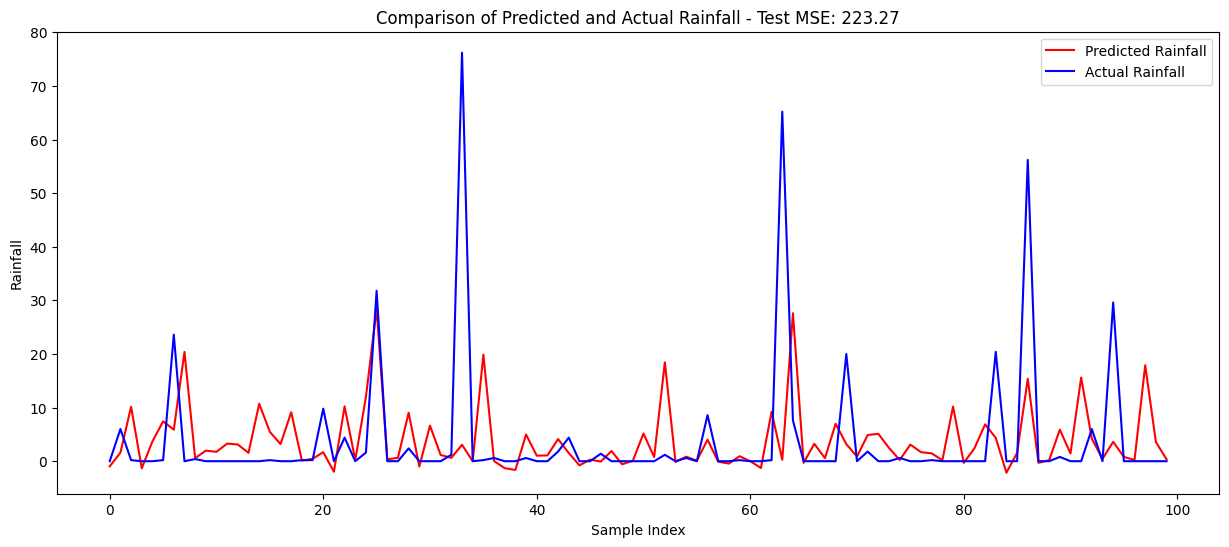

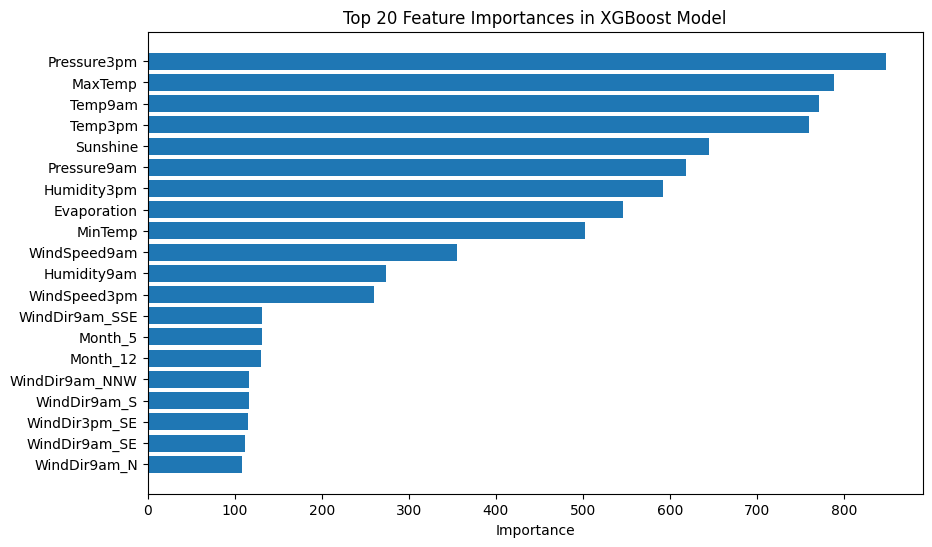

MSE of XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, ...) is :223.26731592970256
This is the waterfall plot of the sample with the maximum residual 176.43313798904418


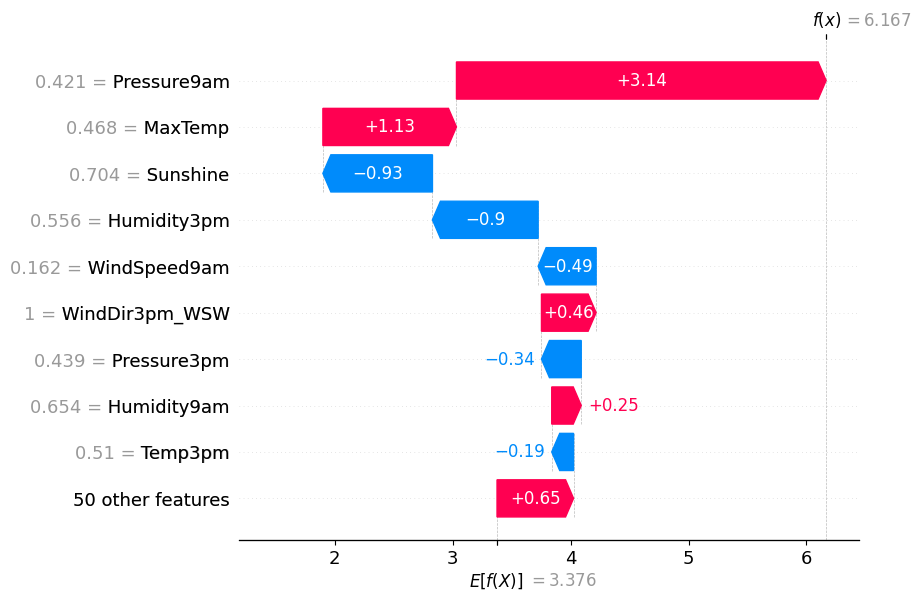

This is the waterfall plot of the sample with the minimum residual 0.0025355732068419456


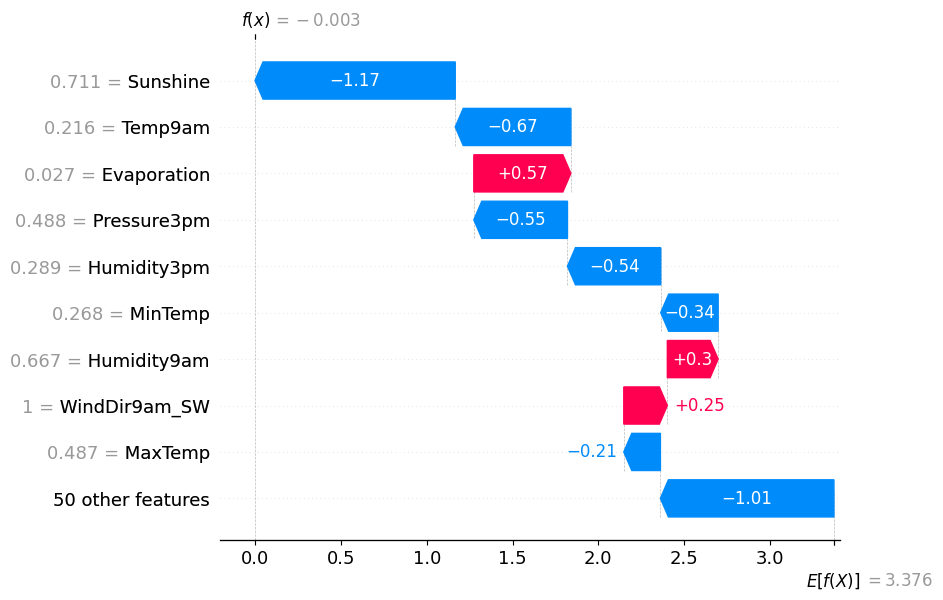

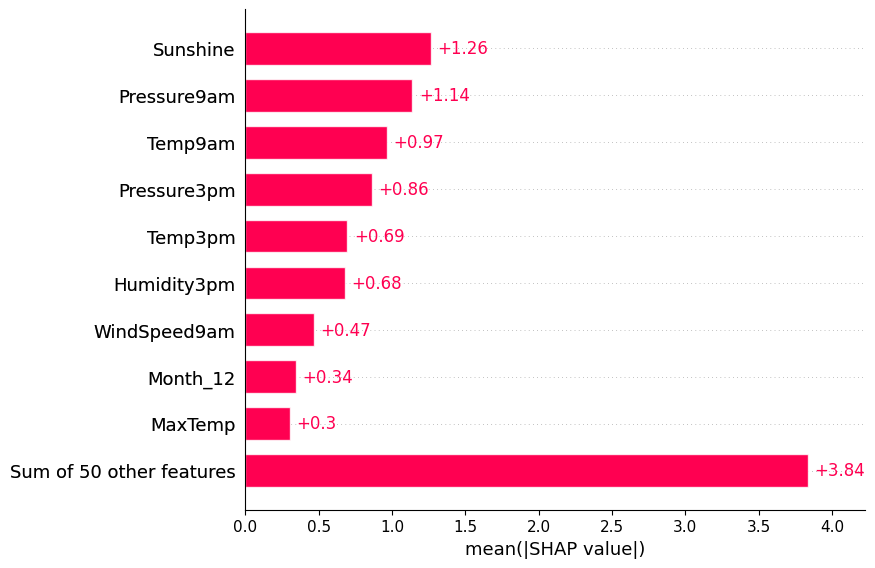

In [10]:
xgbr_brisbane= xgboost_regression(data_brisbane)

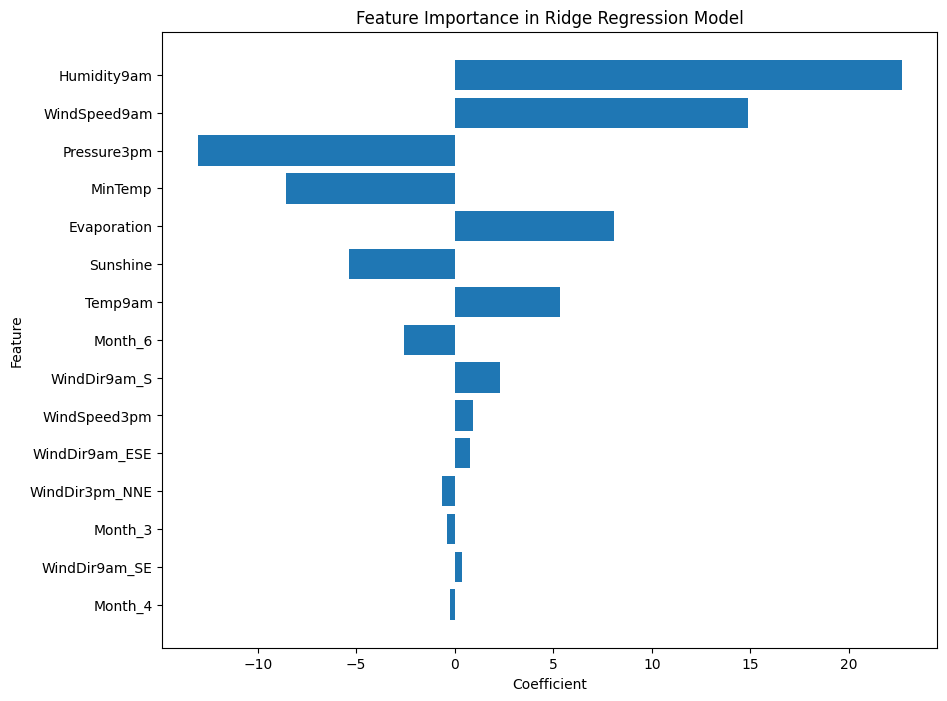

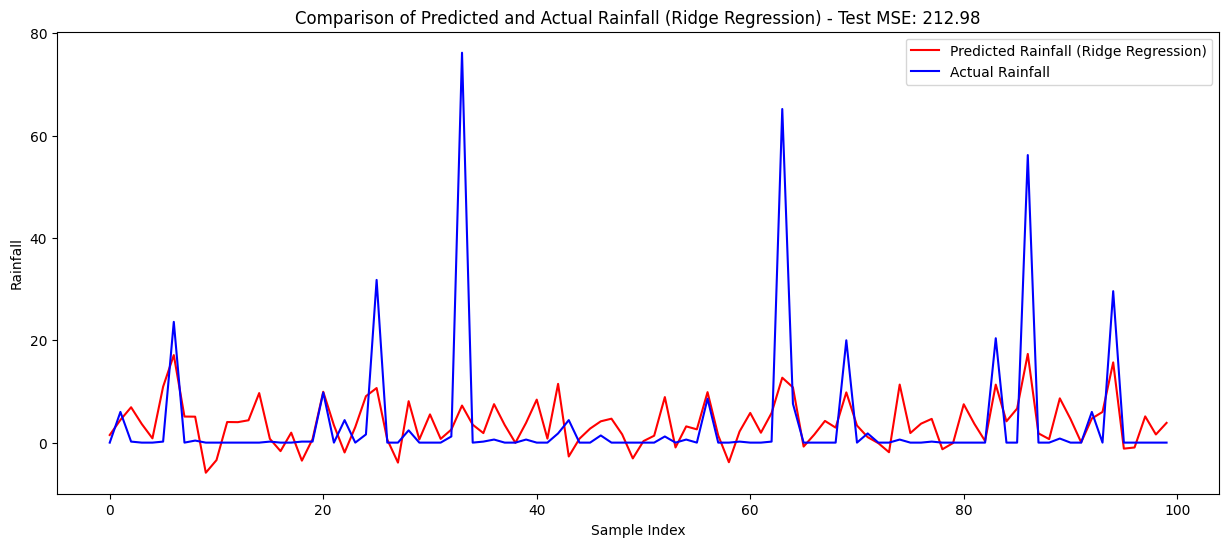

MSE of Ridge(alpha=0.4) is :212.97546101984983
This is the waterfall plot of the sample with the maximum residual 178.02434664817125


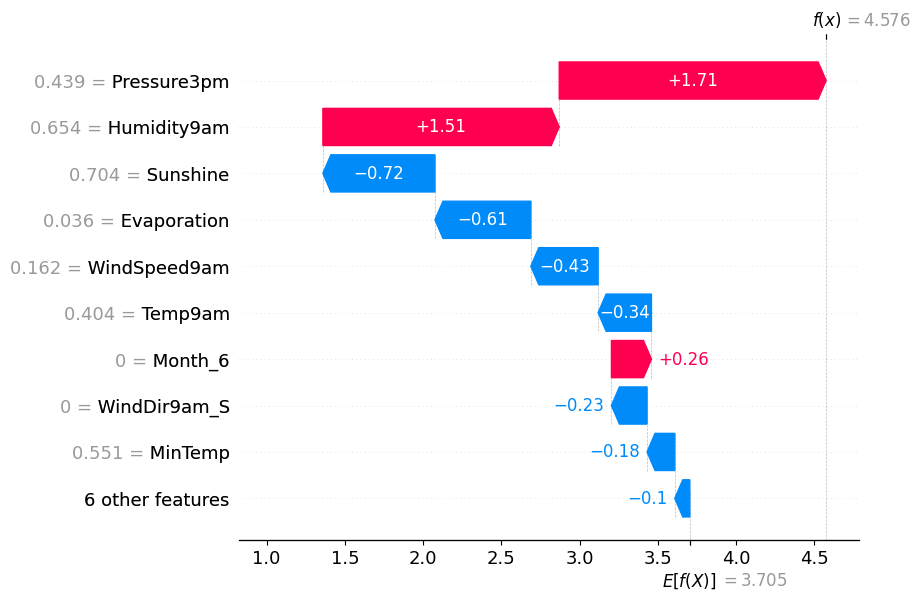

This is the waterfall plot of the sample with the minimum residual 0.034509459740343695


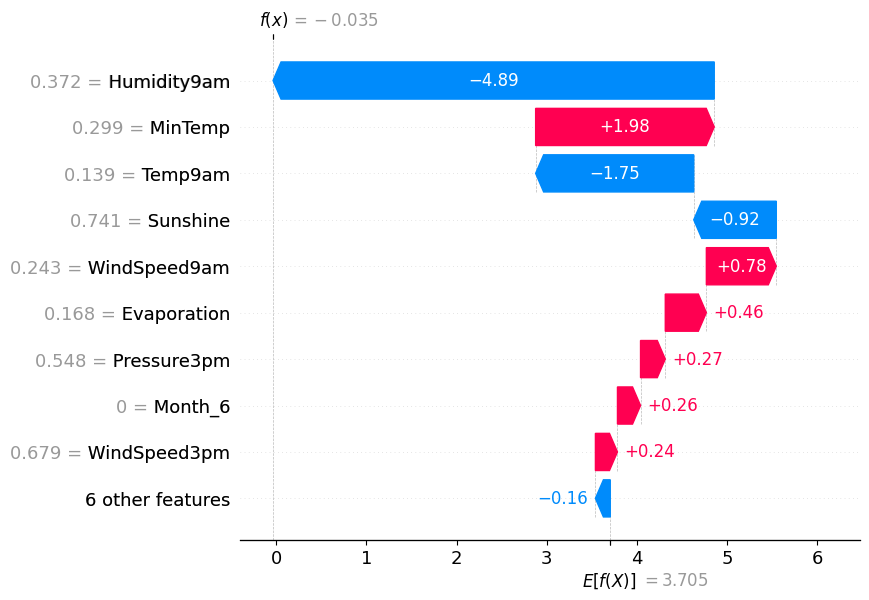

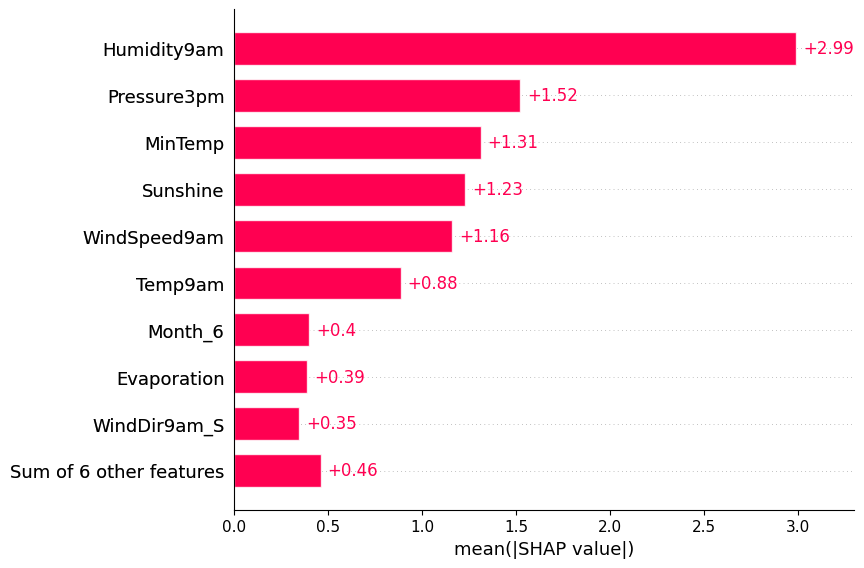

In [11]:
ridge_brisbane= ridge_regression(data_brisbane)

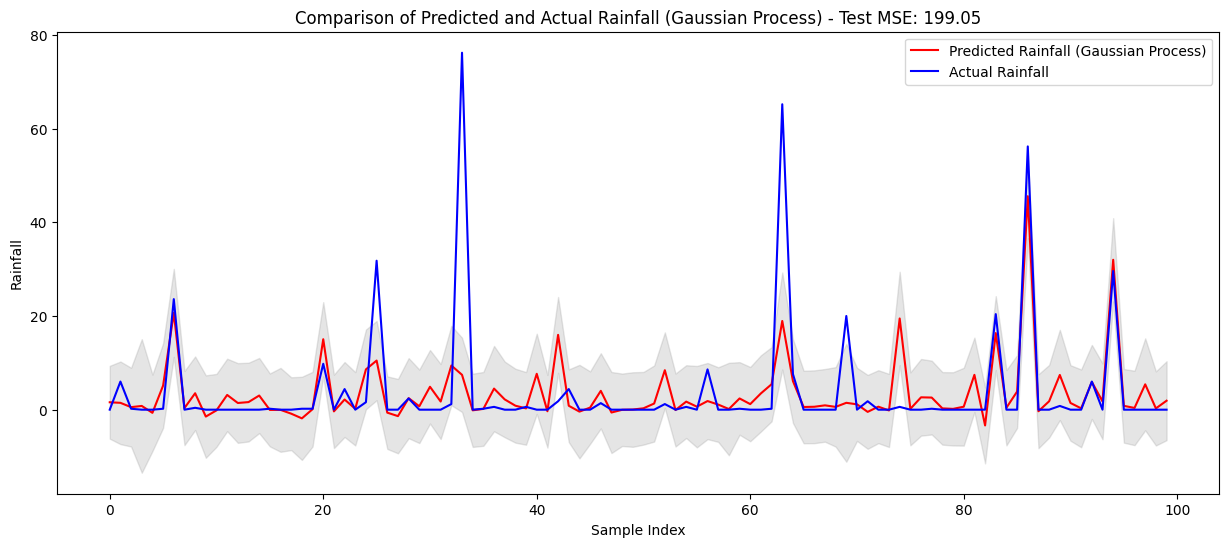

MSE of GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=4, random_state=1) is :199.05049688946477


In [12]:
# may take a while
gp_brisbane= gaussian_process(data_brisbane)

epoch: 0, loss: 28.01650810, test loss: 90.95051918
epoch: 10, loss: 22.19257545, test loss: 83.04322195
epoch: 20, loss: 25.76943398, test loss: 79.13203936
epoch: 30, loss: 31.38049126, test loss: 80.05648966
epoch: 40, loss: 32.14379120, test loss: 80.25997524


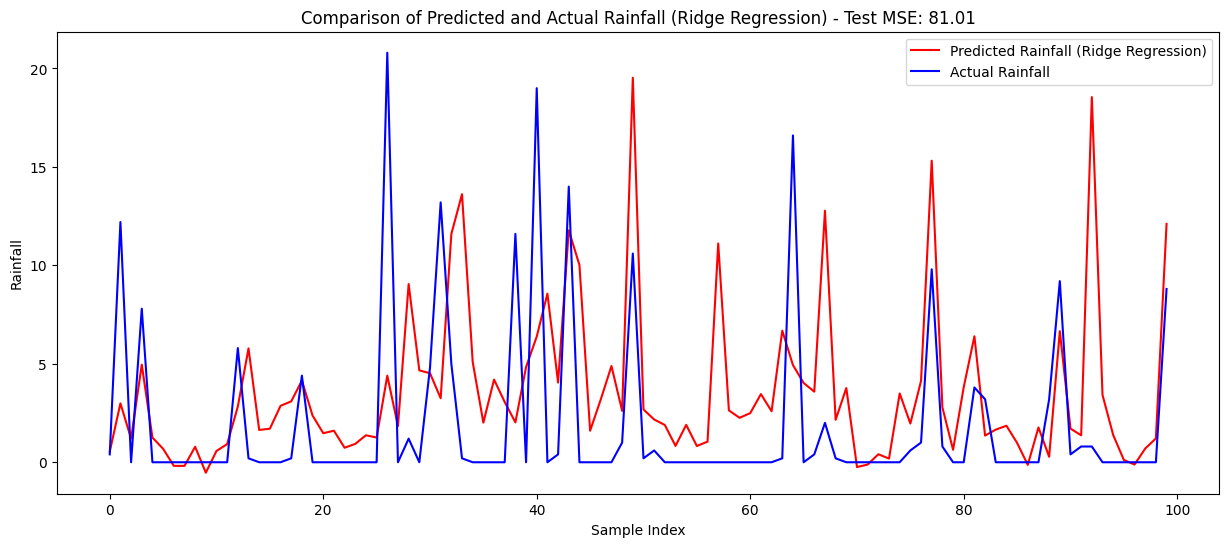

MSE of LSTM(
  (lstm): LSTM(59, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
) is :81.0149314880371


In [13]:
lstm_brisbane=lstm(data_brisbane)

# Analysis for `Townsville`

In [14]:
data_townsville = data_preprocessing("weatherAUS.csv",["Townsville"])

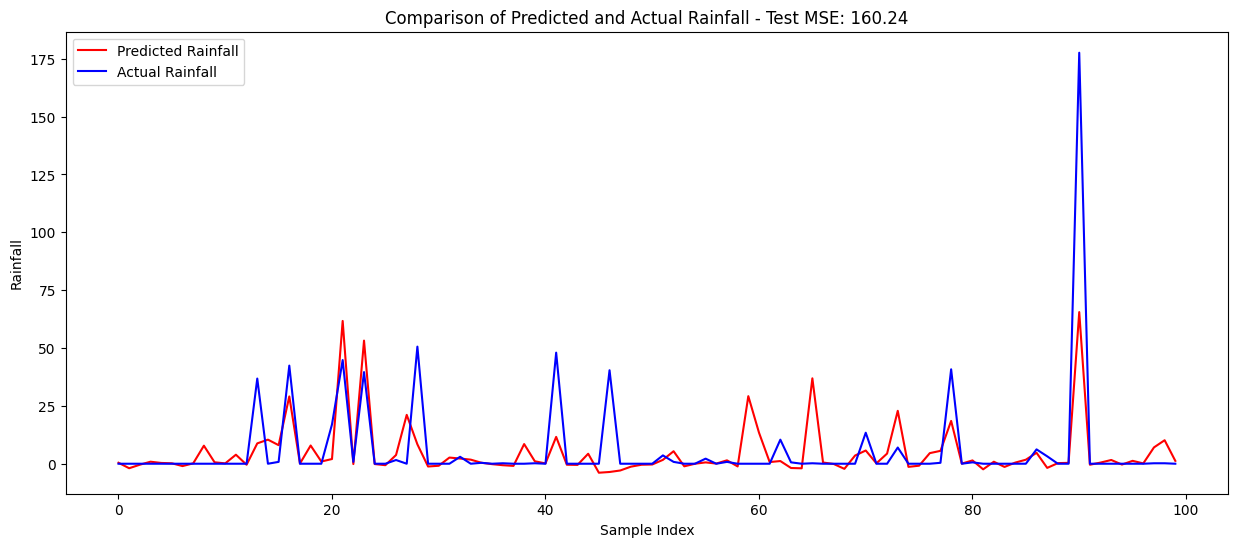

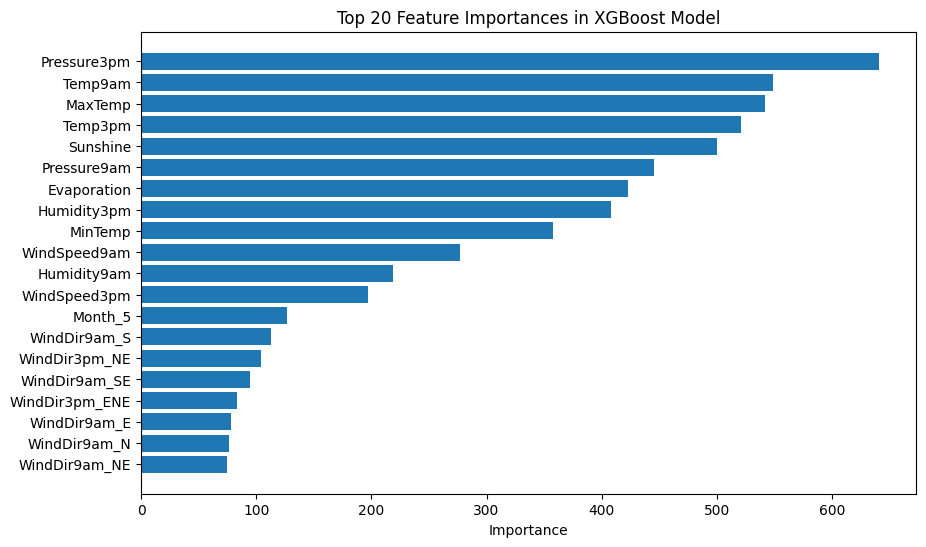

MSE of XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, ...) is :160.2423725781241
This is the waterfall plot of the sample with the maximum residual 132.47103576660157


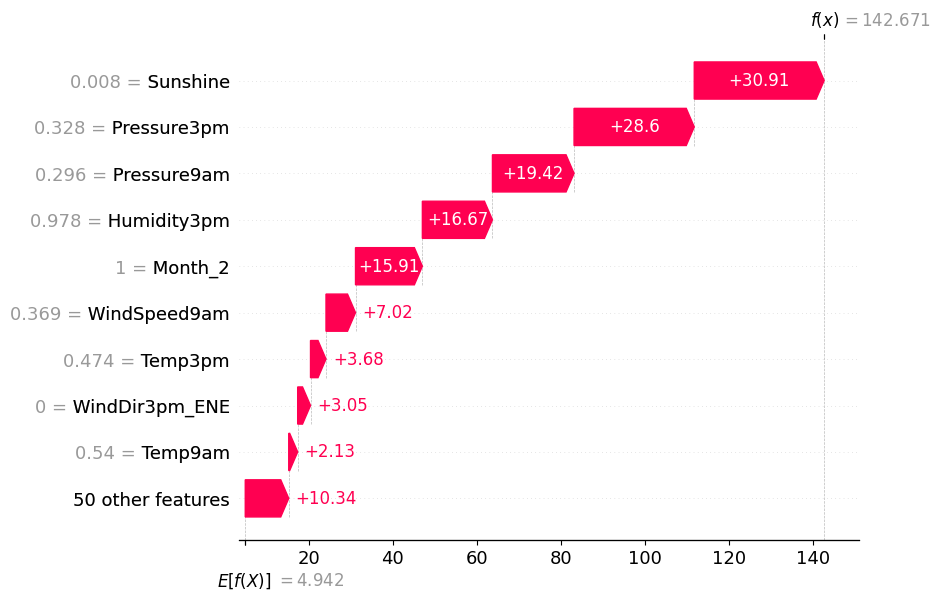

This is the waterfall plot of the sample with the minimum residual 0.0007024295628070831


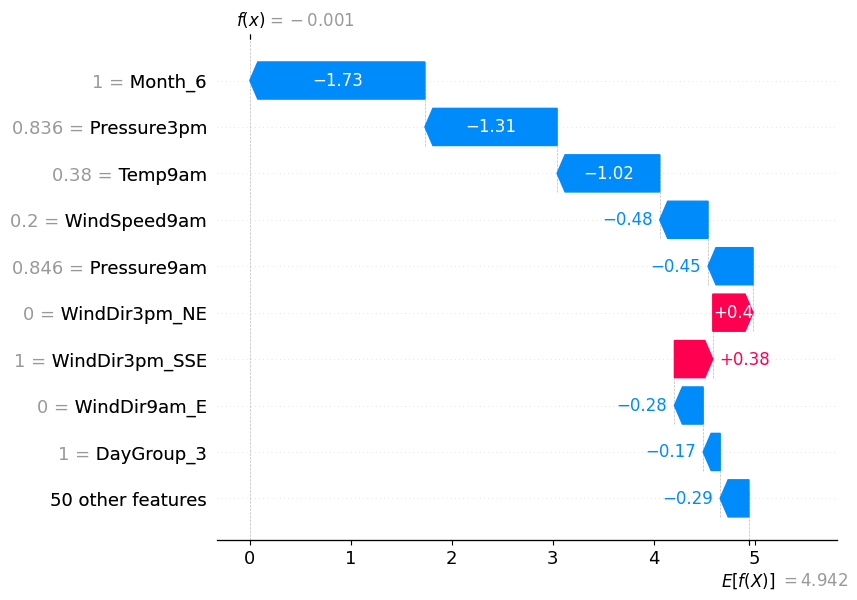

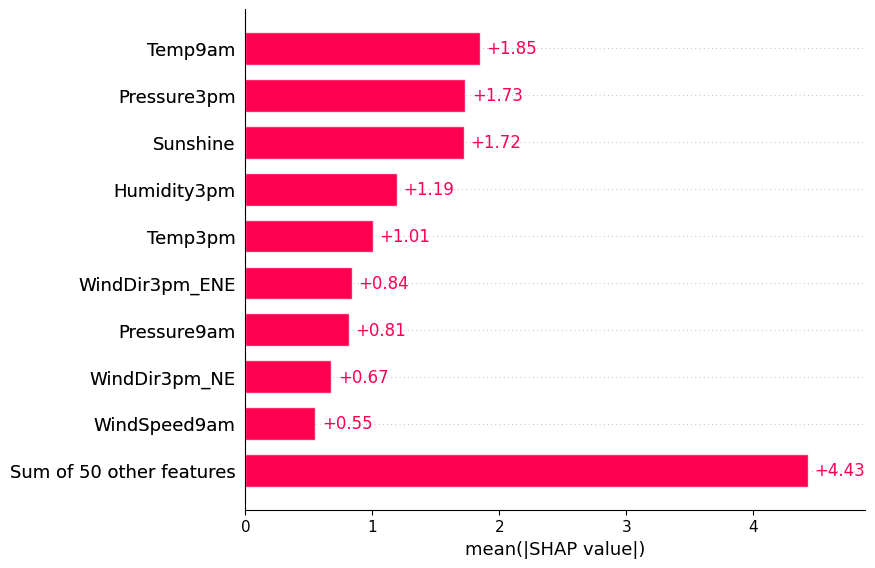

In [15]:
xgbr_townsville= xgboost_regression(data_townsville)

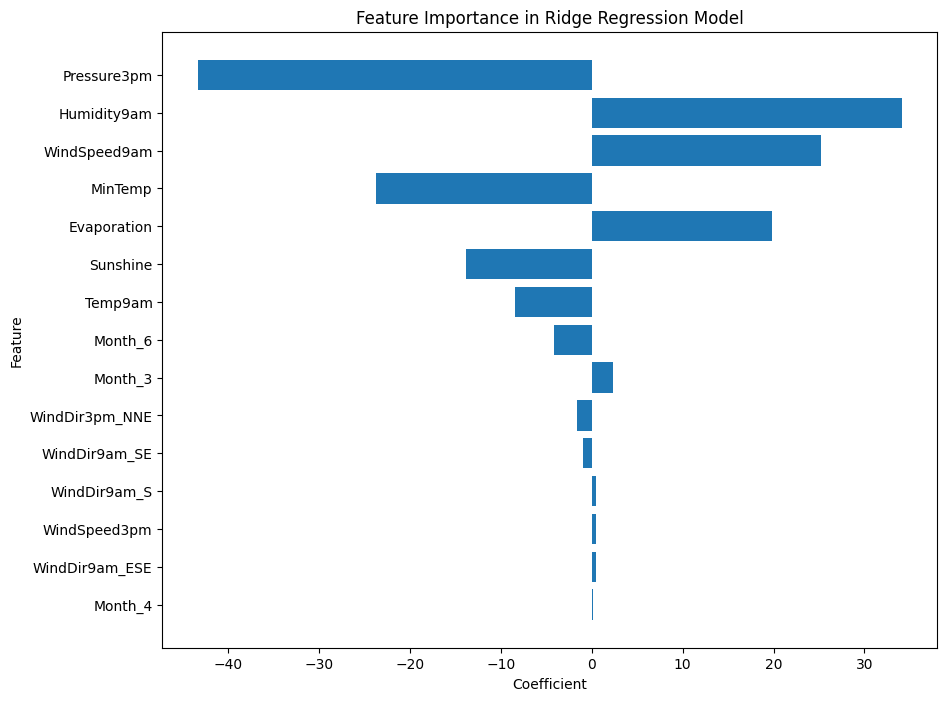

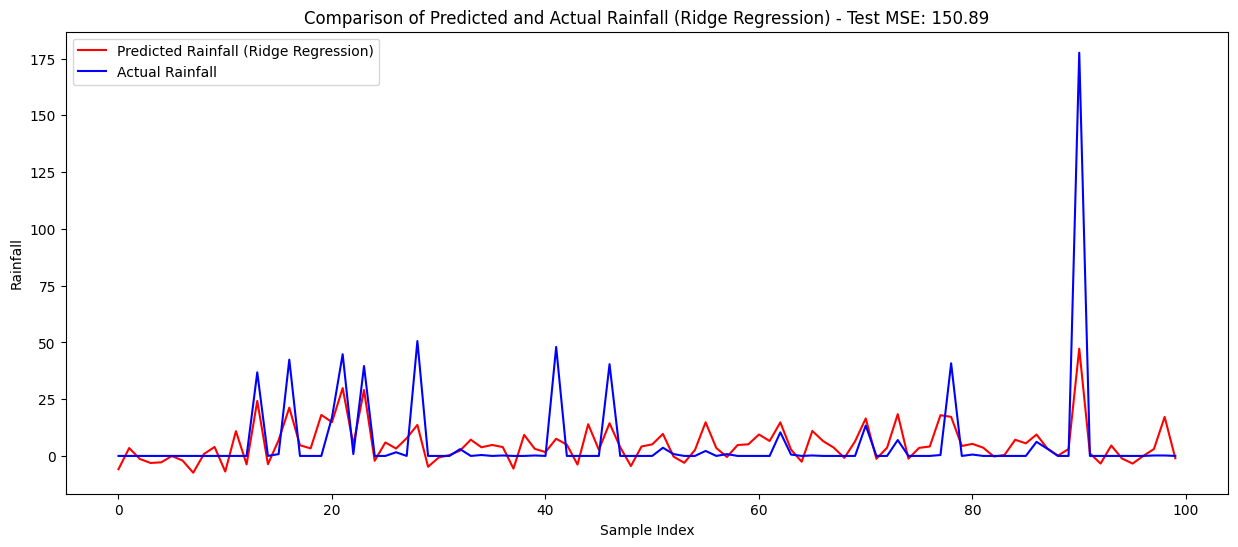

MSE of Ridge(alpha=0.4) is :150.89058532501582
This is the waterfall plot of the sample with the maximum residual 130.34988118887065


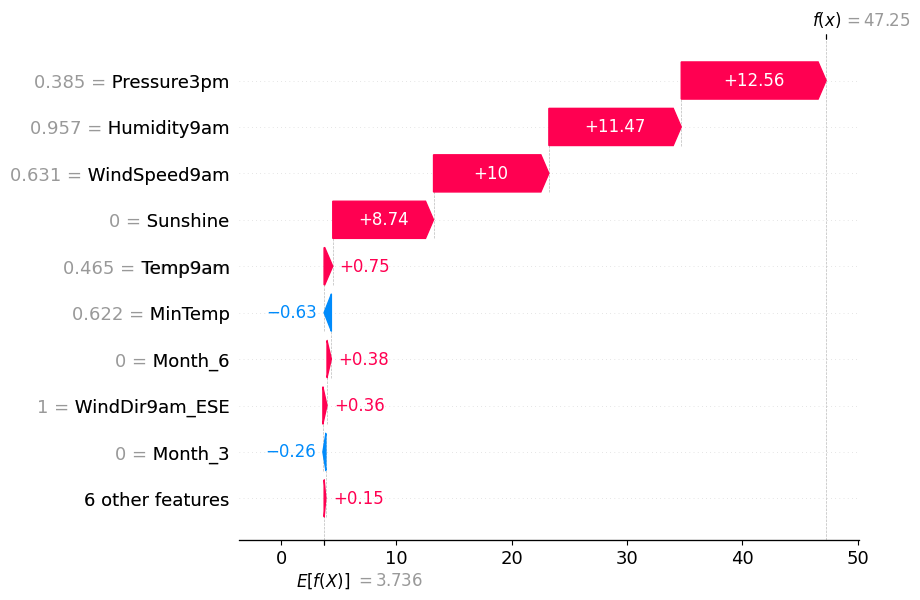

This is the waterfall plot of the sample with the minimum residual 0.003317469394634287


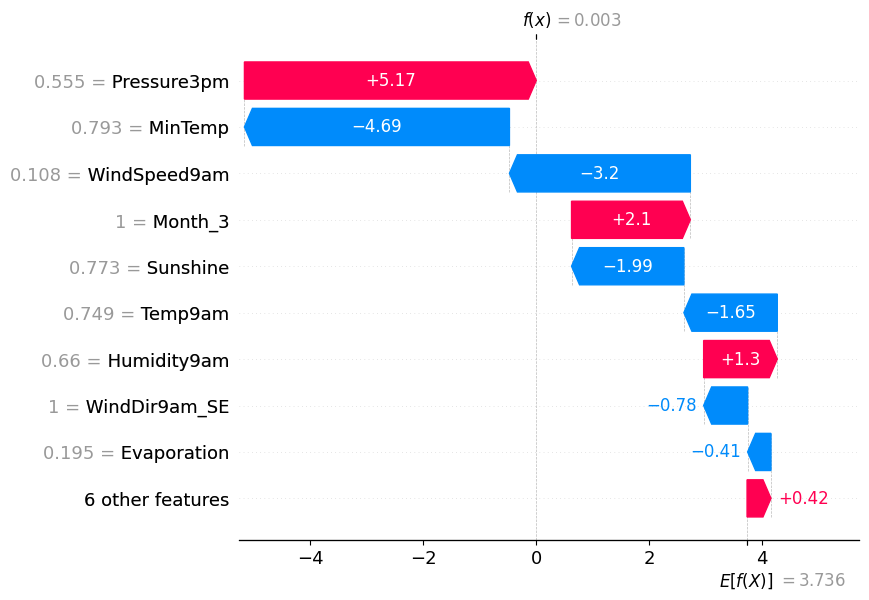

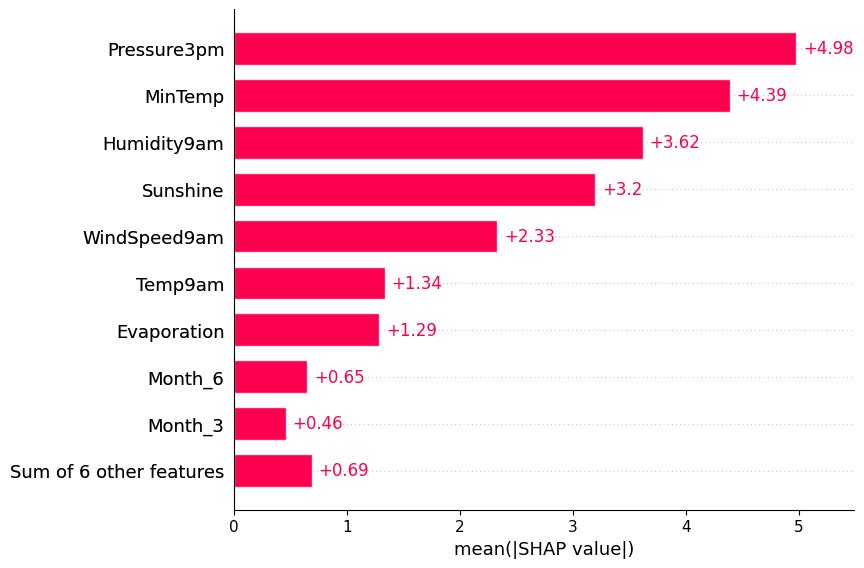

In [16]:
ridge_townsville= ridge_regression(data_townsville)

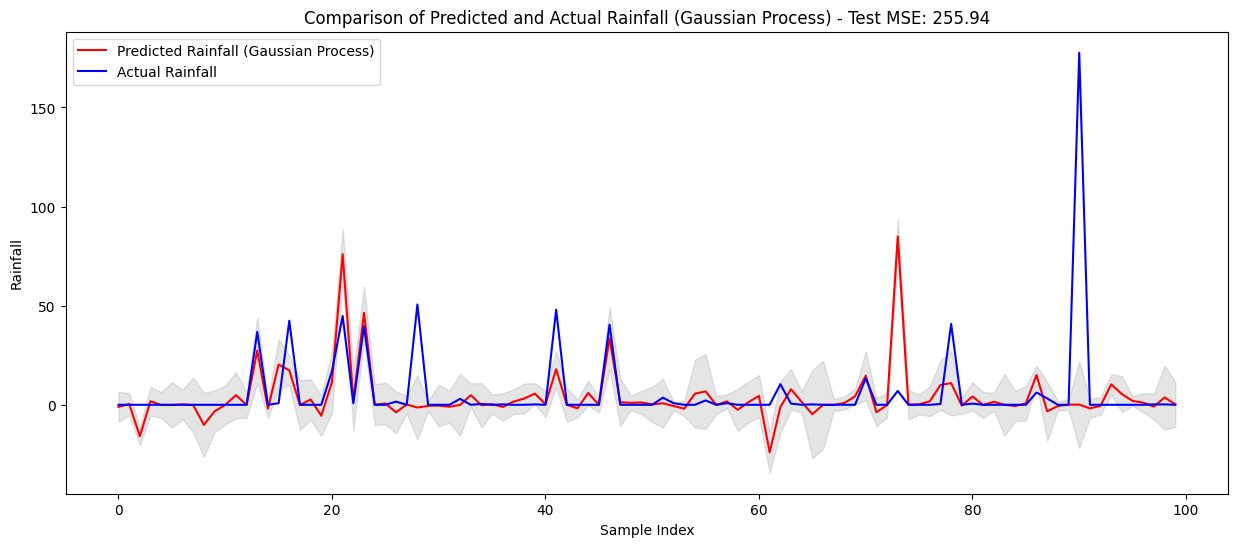

MSE of GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=4, random_state=1) is :255.935168535672


In [17]:
# may take a while
gp_townsville= gaussian_process(data_townsville)

epoch: 0, loss: 13.32394695, test loss: 100.22300476
epoch: 10, loss: 13.81114674, test loss: 90.98314020
epoch: 20, loss: 4.73807955, test loss: 81.50280650
epoch: 30, loss: 1.81091344, test loss: 79.46988841
epoch: 40, loss: 1.77426803, test loss: 77.73458570


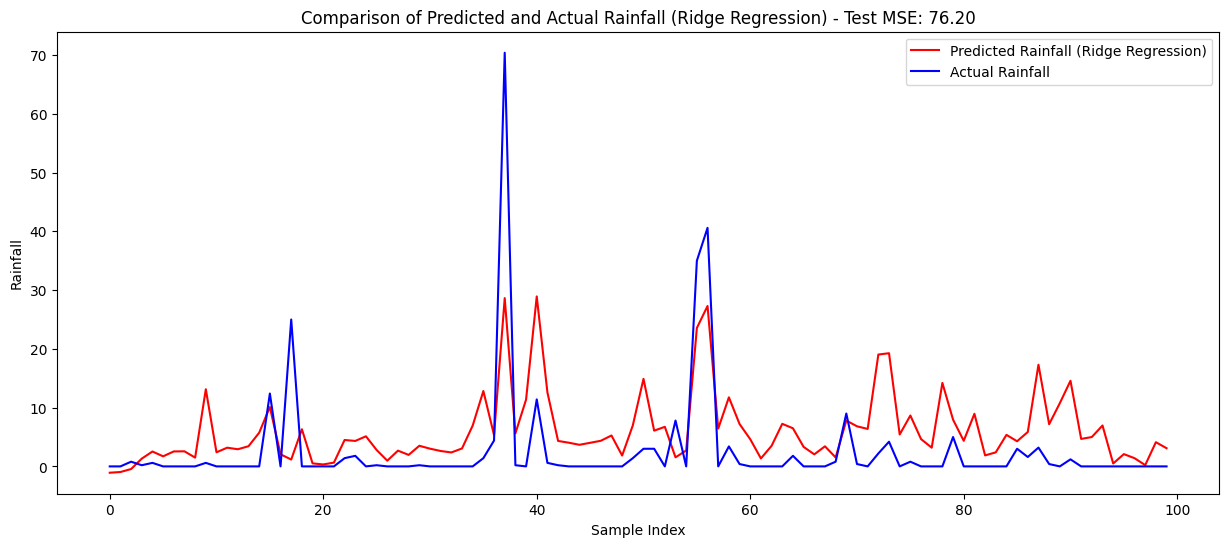

MSE of LSTM(
  (lstm): LSTM(59, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
) is :76.19631881184048


In [18]:
lstm_townsville=lstm(data_townsville)

# Analysis for `Melbourne`

In [19]:
data_melbourne = data_preprocessing("weatherAUS.csv",["Melbourne"])

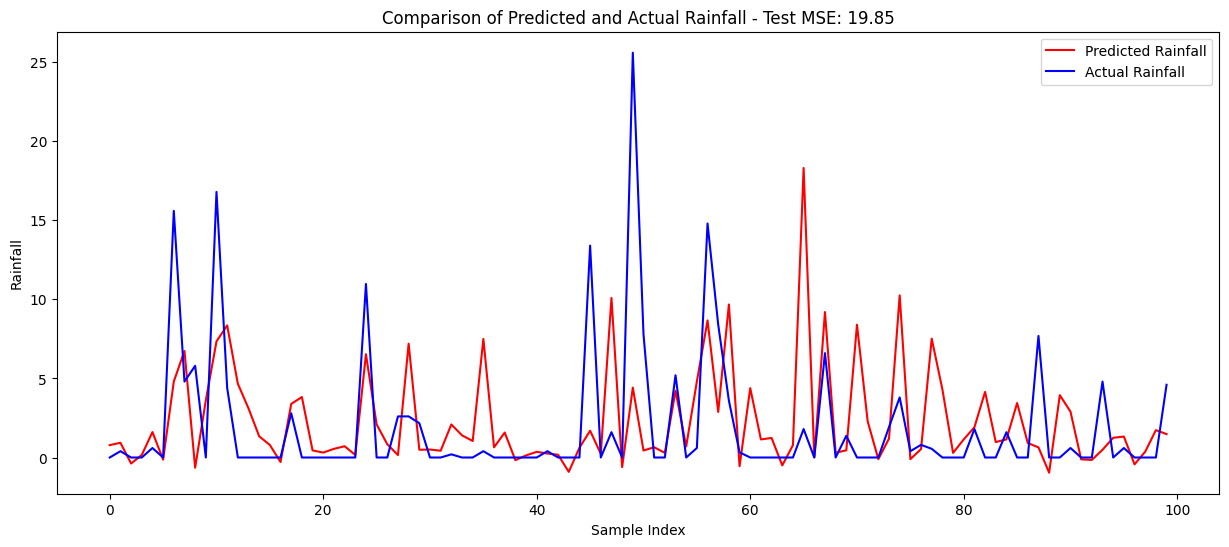

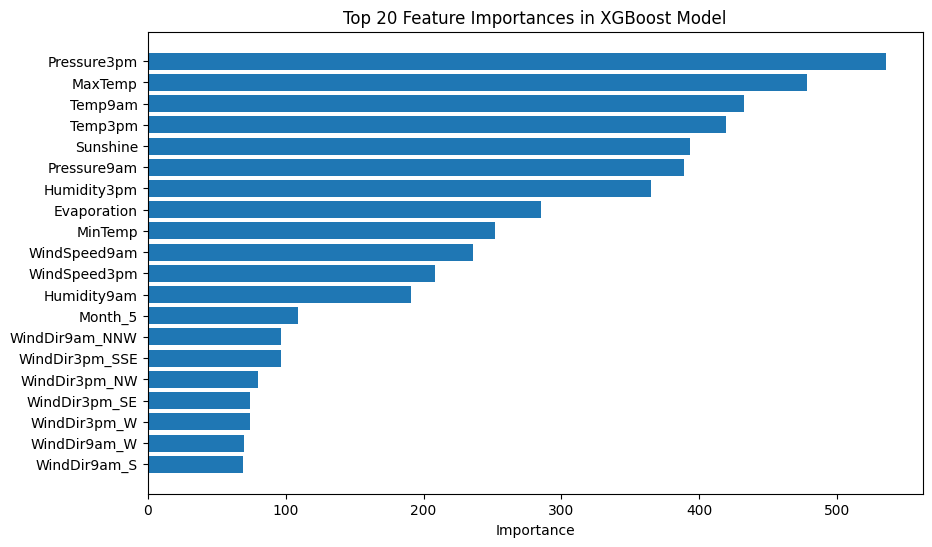

MSE of XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, ...) is :19.847088183366893
This is the waterfall plot of the sample with the maximum residual 43.896528887748715


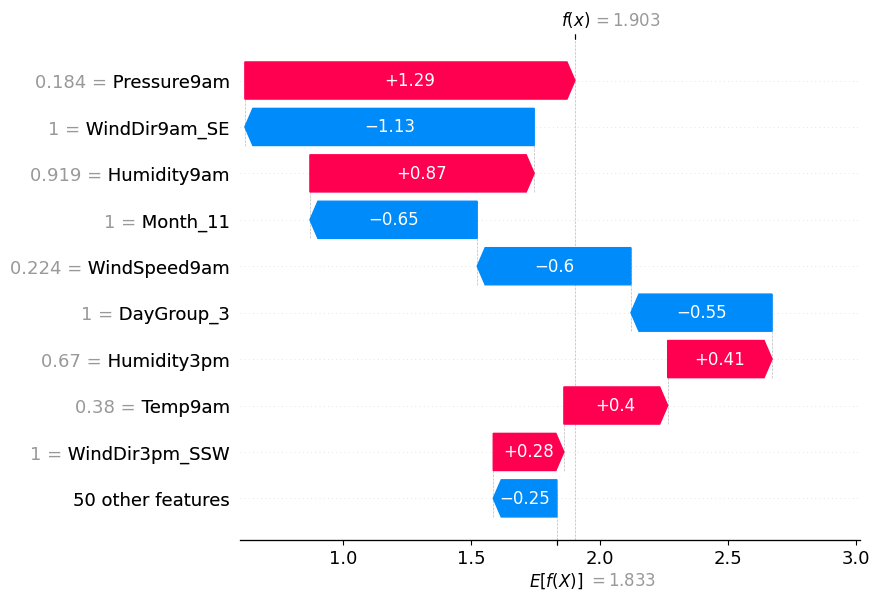

This is the waterfall plot of the sample with the minimum residual 0.00257796049118042


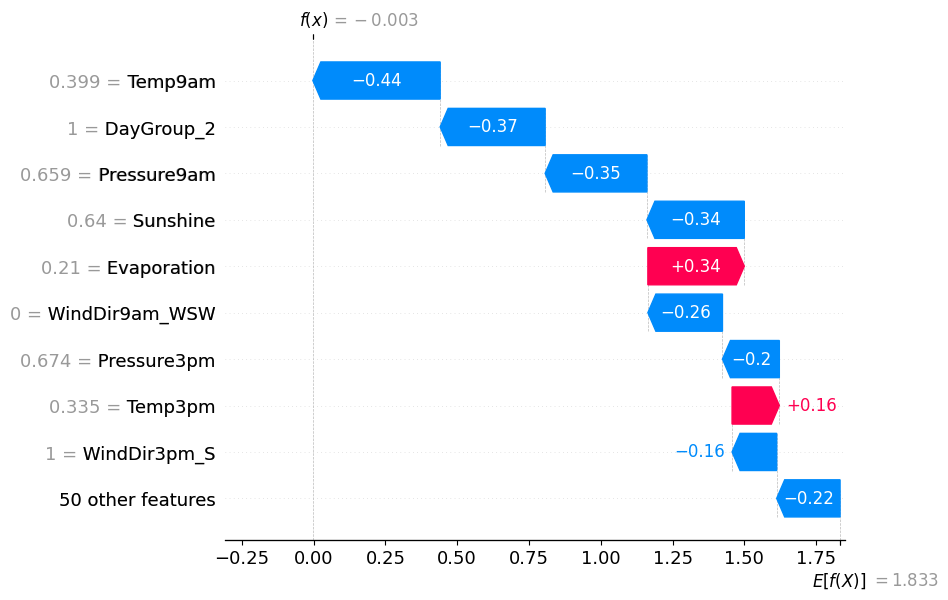

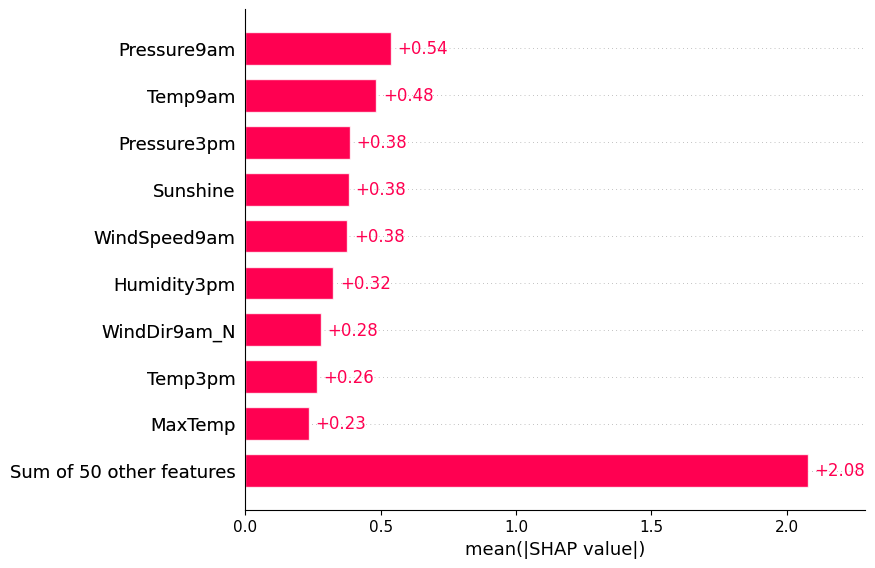

In [20]:
xgbr_melbourne= xgboost_regression(data_melbourne)

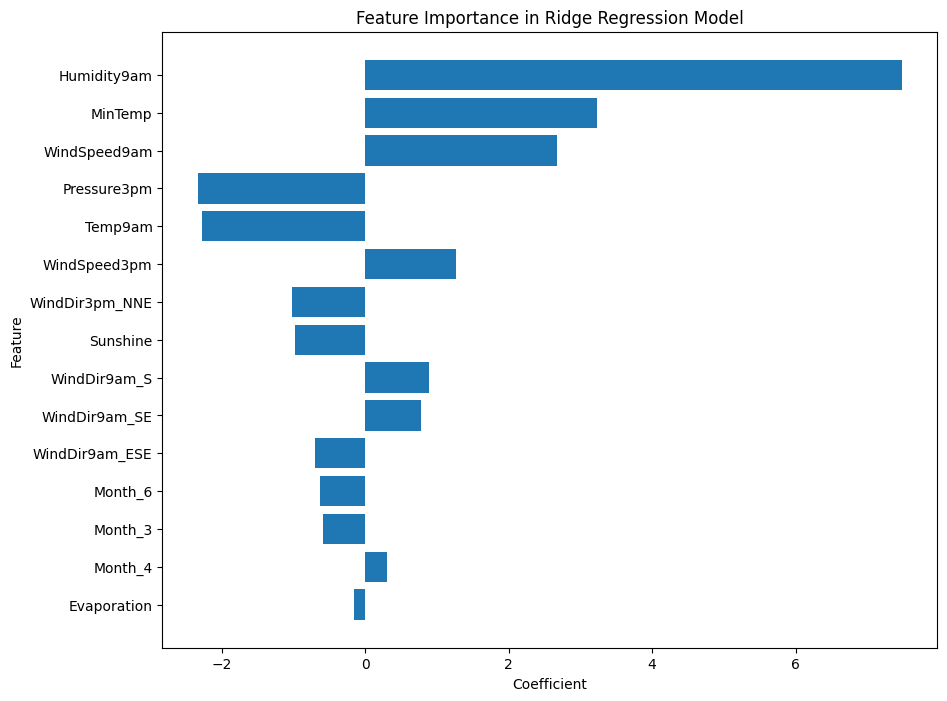

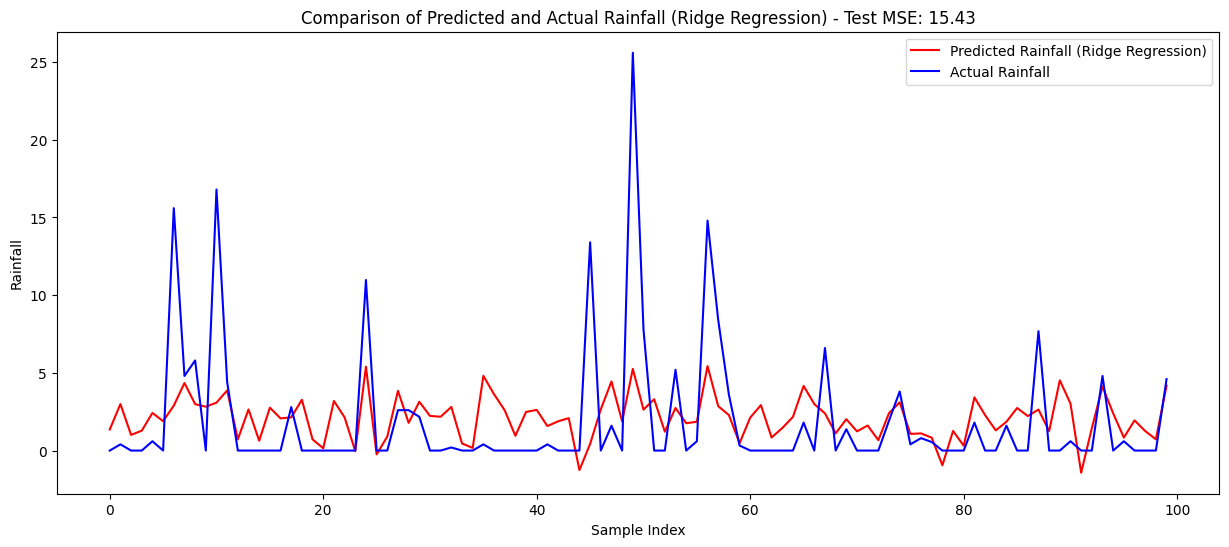

MSE of Ridge(alpha=0.4) is :15.428296330164969
This is the waterfall plot of the sample with the maximum residual 39.85270437150334


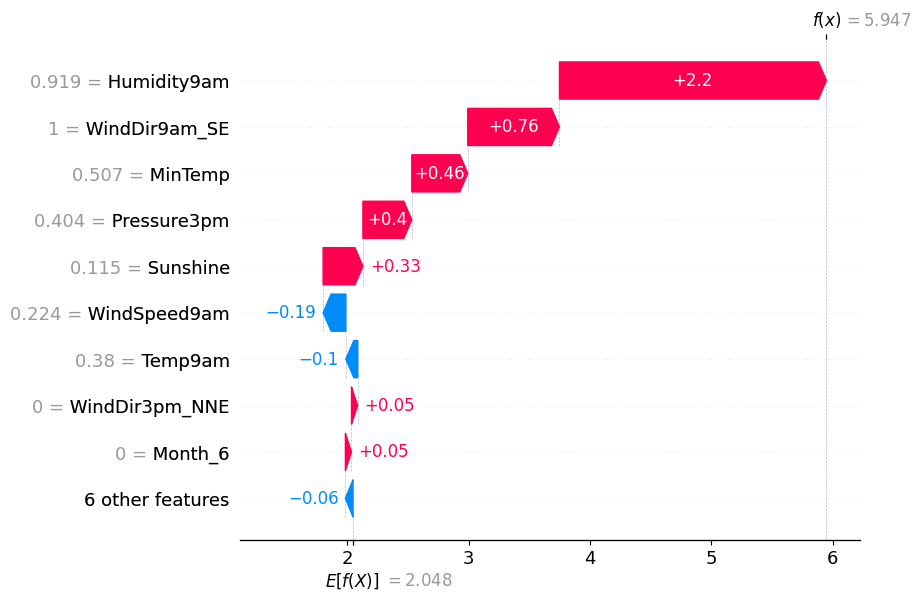

This is the waterfall plot of the sample with the minimum residual 0.0046808059096572485


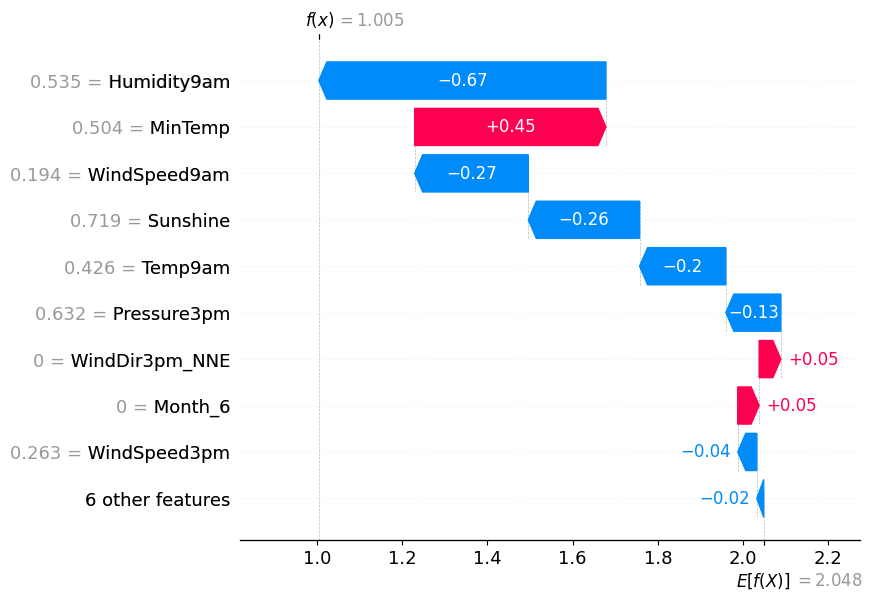

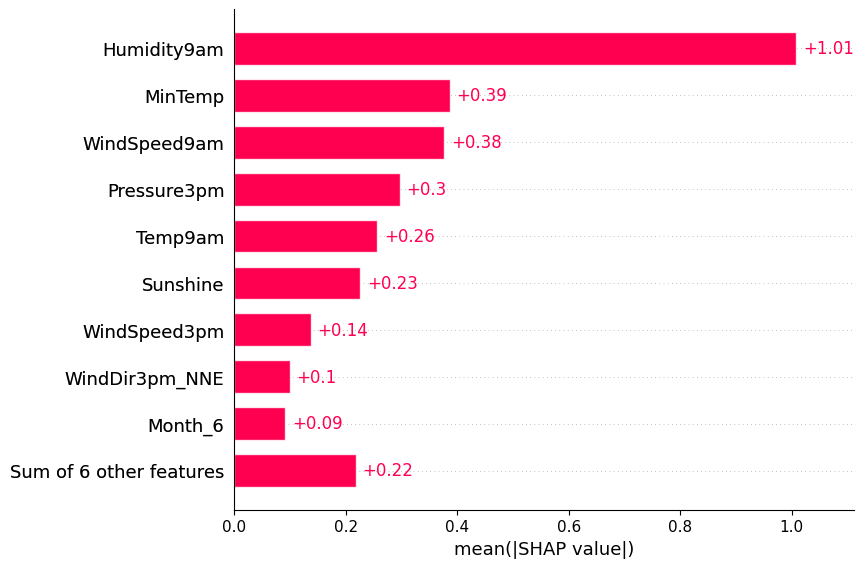

In [21]:
ridge_melbourne= ridge_regression(data_melbourne)

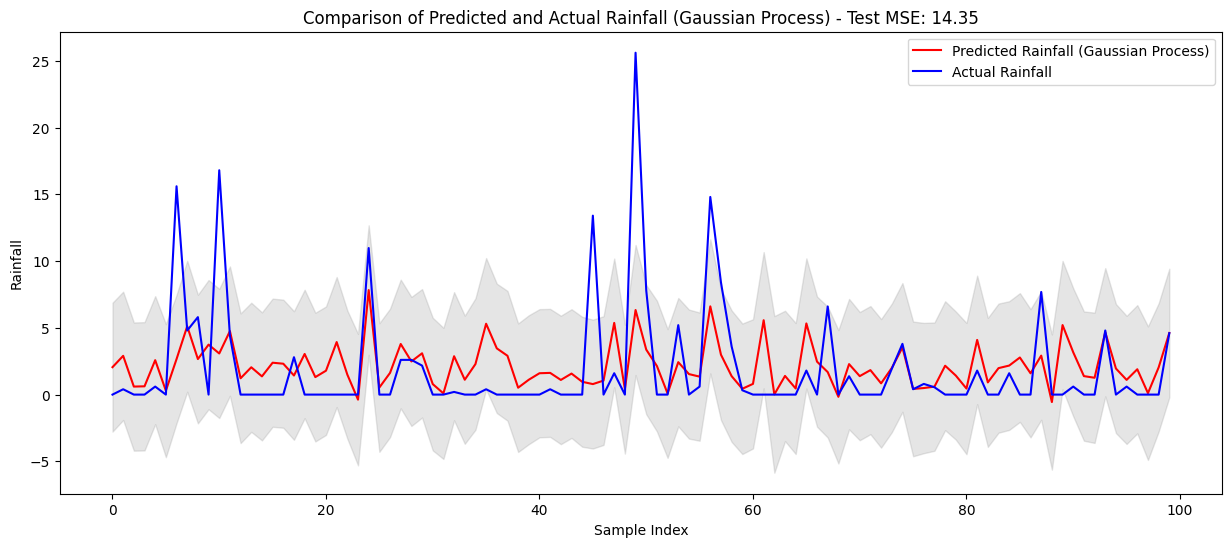

MSE of GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=4, random_state=1) is :14.350778866489863


In [22]:
gp_melbourne= gaussian_process(data_melbourne)

epoch: 0, loss: 4.78254795, test loss: 18.53355492
epoch: 10, loss: 6.08972597, test loss: 17.64249399
epoch: 20, loss: 5.04129171, test loss: 16.75423278
epoch: 30, loss: 4.85504389, test loss: 16.94384617
epoch: 40, loss: 3.69602609, test loss: 15.95873168


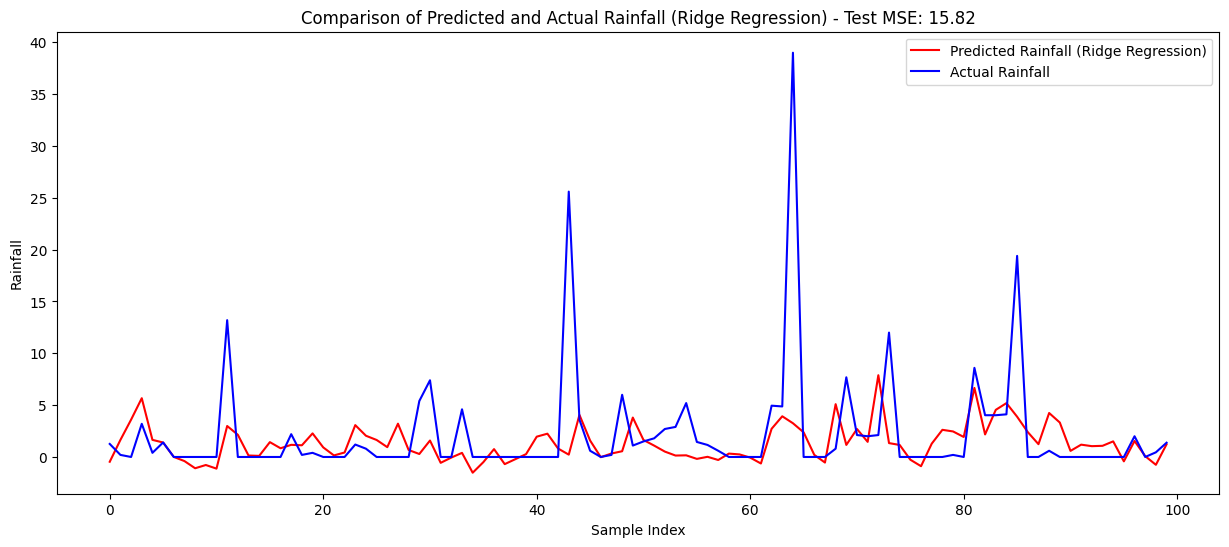

MSE of LSTM(
  (lstm): LSTM(59, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
) is :15.815416680441963


In [23]:
lstm_melbourne=lstm(data_melbourne)

# Final performance

|          | Brisbane | Townsville | Melbourne |
|----------|----------|------------|-----------|
| xgbr     | 176.43   | 160.24     | 19.84     |
| ridge    | 212.97   | 150.89     | 15.42     |
| gaussian | 199.05   | 255.93     | 14.35     |
| lstm    | 80.32    | 76.45      | 15.88     |

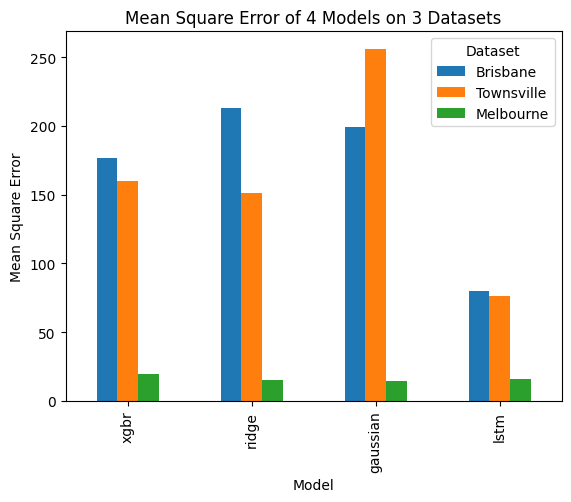

In [24]:
df = pd.DataFrame(
    {
        "Brisbane": [176.43, 212.97, 199.05, 80.32],
        "Townsville": [160.24, 150.89, 255.93, 76.45],
        "Melbourne": [19.84, 15.42, 14.35, 15.88],
    },
    index=["xgbr", "ridge", "gaussian", "lstm"],
)

df.plot.bar()
plt.title("Mean Square Error of 4 Models on 3 Datasets")
plt.xlabel("Model")
plt.ylabel("Mean Square Error")
plt.legend(title="Dataset")
plt.show()